# PrepareData

### Read Data from csv

In [1]:
import pandas as pd
from darts import TimeSeries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../data/'

# 从文件中导入数据到dataframe中
def get_df(file, header=None):
    df = pd.read_csv(file, header=None)
    # df.columns = DF_HEADER.get(key, df.columns)
    df.columns = pd.read_csv("{}.header".format(file.split('.csv')[0])).columns if header is None else header
    return df

dfjob = get_df(DATA_DIR + 'pai_job_table.csv')
dftask = get_df(DATA_DIR + 'pai_task_table.csv')
dfinstance = get_df(DATA_DIR + 'pai_instance_table.csv')
dfsensor = get_df(DATA_DIR + 'pai_sensor_table.csv')
dfgroup = get_df(DATA_DIR + 'pai_group_tag_table.csv')
dfp_spec = get_df(DATA_DIR + 'pai_machine_spec.csv')
dfm_metric = get_df(DATA_DIR + 'pai_machine_metric.csv')

### 进行表连接

In [3]:
def get_dfia(dfi):
    dfi_s = dfi[dfi.start_time > 0][['job_name','task_name','start_time']].groupby(['job_name','task_name']).min()  # start_time
    dfi_e = dfi[dfi.end_time > 0][['job_name','task_name','end_time']].groupby(['job_name','task_name']).max()  # end_time
    dfi_m = dfi[(dfi.start_time > 0) & (dfi.end_time > 0)][['job_name','task_name','end_time','start_time']]
    dfi_m['runtime'] = dfi_m.end_time-dfi_m.start_time
    dfi_m = dfi_m.groupby(['job_name','task_name']).mean()[['runtime']].reset_index() # runtime
    dfi_u = dfi[['job_name','task_name','status']].drop_duplicates().groupby(['job_name','task_name']).max() # status
    dfia = dfi_u
    for df in [dfi_s, dfi_e, dfi_m]:
        dfia = dfia.merge(df, on=['job_name','task_name'], how='left')
    return dfia

def get_dfa(dft, dfj, dfi, dfg):
    print('dft + dfj ...')
    dfa = dft.merge(dfj, on=['job_name'], suffixes = ['','_j'])
    dfa.loc[dfa.start_time==0, 'start_time'] = np.nan
    dfa.loc[dfa.start_time==0, 'end_time'] = np.nan
    dfa['runtime'] = dfa.end_time - dfa.start_time
    print('dft + dfj + dfi ...')
    dfia = get_dfia(dfi)
    dfa = dfa.merge(dfia, on=['job_name','task_name'], suffixes=['','_i'])
    dfa['duration_min'] = dfa.runtime_i / 60  # duration of instances
    dfa['wait_time'] = dfa.start_time_i - dfa.start_time # task wait time
    dfa['start_date']=dfa.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai') # task start time
    # dfa = dfa[dfa.status=='Terminated']
    print('dft + dfj + dfi + dfg ...')
    dfa = dfa.merge(dfg[[x for x in dfg.columns if x != 'user']], on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfa.loc[dfa.group.isnull(),'group'] = dfa.loc[dfa.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfa

dfa = get_dfa(dftask, dfjob, dfinstance, dfgroup)

dft + dfj ...
dft + dfj + dfi ...
dft + dfj + dfi + dfg ...


In [4]:
def get_dfiw(dfi):
    dfiw = dfi.sort_values(['status','start_time','end_time'])
    dfiw.drop_duplicates(subset=['worker_name'], keep='last', inplace=True)
    dfiw.dropna(subset=['worker_name'], inplace=True)
    dfiw['runtime'] = dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['end_time'] \
                    - dfiw[(dfiw.start_time>0)&(dfiw.end_time>0)]['start_time']
    dfiw.loc[dfiw.start_time==0, 'start_time'] = np.nan
    dfiw.loc[dfiw.start_time==0, 'end_time'] = np.nan
    return dfiw

def get_dfw(dfi, dft, dfg):
    dfw = get_dfiw(dfi)
    dfw['start_date']=dfw.start_time.apply(pd.Timestamp, unit='s', tz='Asia/Shanghai')
    print('dfi + dft ...')
    dfw = dfw.merge(dft, on=['job_name','task_name'], how='left', suffixes=['', '_t'])
    print('dfi + dft + dfg ...')
    dfw = dfw.merge(dfg, on='inst_id', how='left')  # reserve NaN ones by how='left'
    dfw.loc[dfw.group.isnull(),'group'] = dfw.loc[dfw.group.isnull(), 'user']  # fill group==NaN ones with user
    return dfw

dfw = get_dfw(dfinstance, dftask, dfgroup)

dfi + dft ...
dfi + dft + dfg ...


In [5]:
dfws = dfw.merge(dfp_spec.drop(columns={'gpu_type'}), on='machine', how='left')
dfws = dfws.merge(dfsensor.drop(columns=['job_name','task_name','inst_id','machine']), on='worker_name')

In [6]:
dfas = dfws.groupby(['job_name','task_name'])[['cpu_usage','gpu_wrk_util','avg_mem','avg_gpu_wrk_mem','plan_cpu','plan_gpu','plan_mem','cap_cpu','cap_gpu','cap_mem']].sum()
dfas = dfa.drop(columns=['plan_cpu','plan_mem','plan_gpu']).merge(dfas, on=['job_name','task_name'])

# 时间模型

### 一周内提交的Task数

Hour 0 Date: 1970-01-25 00:00:03+08:00


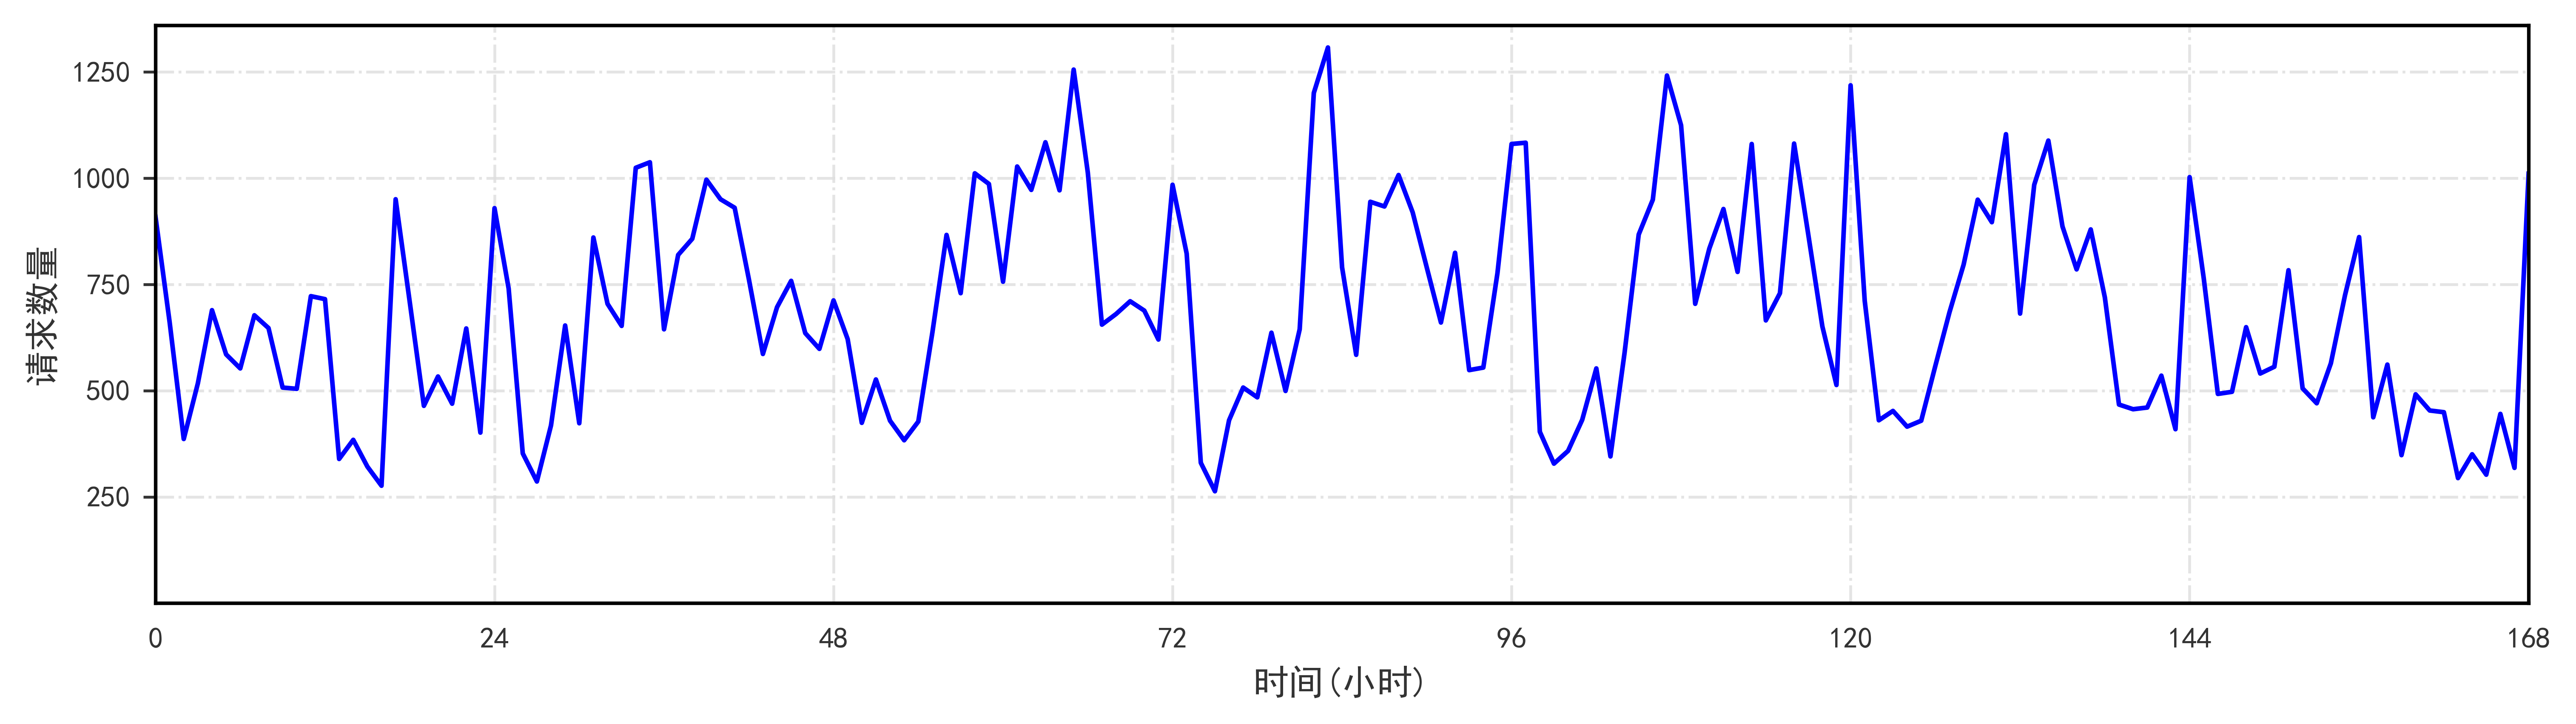

In [7]:
offset = -600
plt.rcParams['font.sans-serif'] = ['SimHei']  # 汉字字体,优先使用楷体，如果找不到楷体，则使用黑体
matplotlib.rcParams.update({"font.size": 14})
dfa['hourofyear'] = dfa.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dftcc = dfa.groupby('hourofyear').count()[['job_name']].reset_index()
dftcc['hour'] = dftcc.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
num_days = 7
plt.plot(dftcc[(dftcc.hour>=0)&(dftcc.hour<24*num_days+1)].set_index('hour')[['job_name']], color='blue')
plt.xlabel('时间(小时)')
plt.ylabel('请求数量')
plt.grid(alpha=0.8, linestyle='-.')
plt.xlim(0, 24*num_days)
plt.ylim(0, )
plt.yticks([250,500,750,1000,1250])
_ = plt.xticks([24 * x for x in range(num_days+1)])

### 一周内资源的需求量

Hour 0 Date: 1970-01-25 00:00:03+08:00


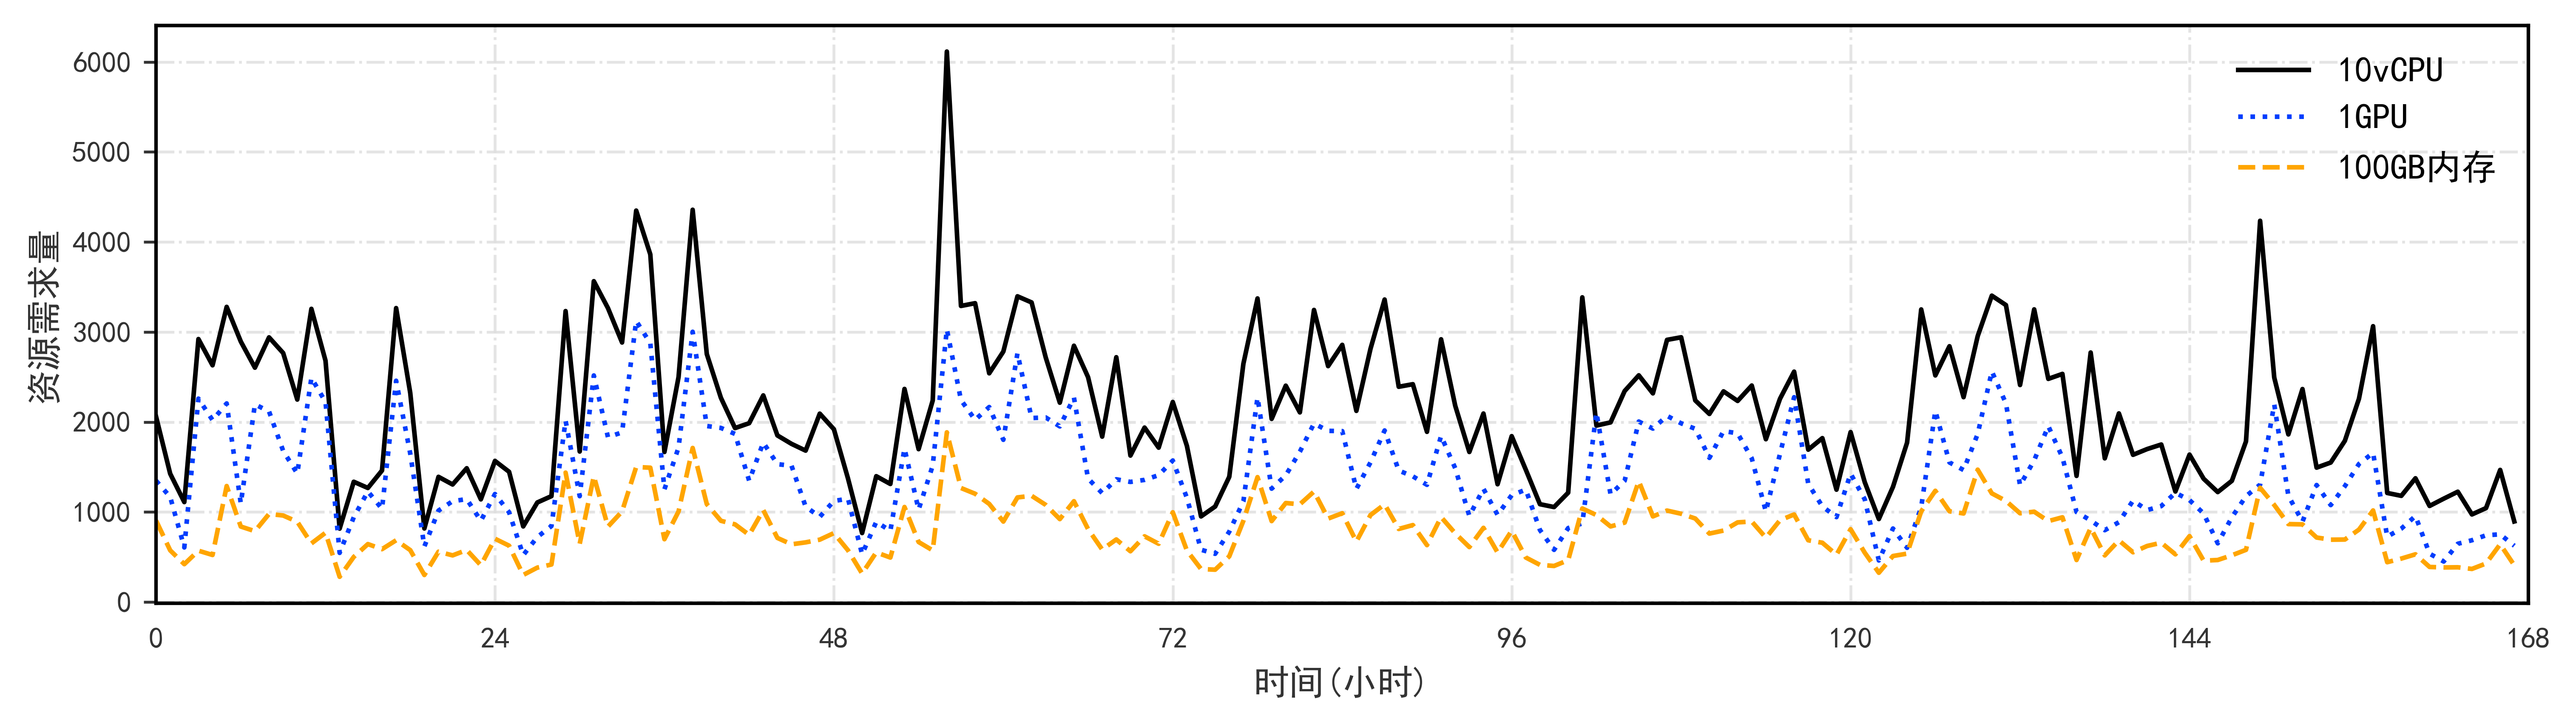

In [8]:
dfw['hourofyear'] = dfw.start_date.apply(lambda c: c.dayofyear * 24 + c.hour)
dfitcr = dfw.groupby('hourofyear').sum()[['plan_cpu','plan_gpu','plan_mem']].reset_index()
dfitcr['hour'] = dfitcr.hourofyear + offset
print('Hour 0 Date: {}'.format(dfa[dfa.hourofyear==-offset].start_date.min()))

plt.figure(figsize=(12,3), dpi=600)
ax = plt.axes()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
num_days = 7

plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_cpu']/1000, label='10vCPU', linestyle='solid')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_gpu']/100, label='1GPU', linestyle='dotted')
plt.plot(dfitcr[(dfitcr.hour>=0)&(dfitcr.hour<24*num_days)].set_index('hour')['plan_mem']/100, label='100GB内存', color='orange', linestyle='dashed')
plt.legend(loc='upper left')
plt.xlabel('时间(小时)')
plt.ylabel('资源需求量')
plt.grid(alpha=0.8, linestyle='-.')
plt.legend(ncol=1, loc='best')
plt.xlim(0, 24*num_days)
_ = plt.xticks([24 * x for x in range(num_days+1)])

# 时序预测

### 任务提交数量预测

以分钟为基本时间单位

In [24]:
# 生成 min 列表示时间顺序
dfa['minofyear'] = dfa.start_date.apply(lambda c: (c.dayofyear * 24)*60 + (c.hour)*60 + c.minute)
# 按照分钟进行聚合 统计job的数量
dftcc = dfa.groupby('minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
dftcc.sort_values("minofyear", inplace=True)

In [34]:
dfa.head()

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,...,end_time_i,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload,hourofyear,minofyear
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,...,2695847.0,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN,780.0,46807.0
1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,600.0,29.296875,100.0,MISC,...,3399732.0,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN,976.0,58579.0
2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,600.0,29.296875,50.0,MISC,...,2158213.0,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN,629.0,37791.0
3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,600.0,9.765625,10.0,MISC,...,NaN,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,635.0,38136.0
4,704783be2a4b7f88b8d2e4ee,ps,10.0,Running,2172974.0,2173216.0,600.0,19.531250,NaN,NaN,...,NaN,NaN,NaN,NaN,1970-01-26 11:36:14+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,635.0,38136.0


In [32]:
# 以10分钟为单位统计
dfa_minofyear_notnoll = dfa.dropna(subset=['minofyear'])
dfa_minofyear_notnoll['10minofyear'] =  dfa_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)

C:\Users\liduo\AppData\Local\Temp\ipykernel_6864\3193431723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfa_minofyear_notnoll['10minofyear'] =  dfa_minofyear_notnoll['minofyear'].apply(lambda c: int(c/10)*10)


In [35]:
dftcc_10min = dfa_minofyear_notnoll.groupby('10minofyear').count()[['job_name']].reset_index()
# 再按照 min 顺序进行排序
dftcc_10min.sort_values("10minofyear", inplace=True)

In [33]:
dfa_minofyear_notnoll.head()

,job_name,task_name,inst_num,status,start_time,end_time,plan_cpu,plan_mem,plan_gpu,gpu_type,...,runtime_i,duration_min,wait_time,start_date,gpu_type_spec,group,workload,hourofyear,minofyear,10minofyear
0,c936346f45eccd34bf748541,tensorflow,1.0,Terminated,2693235.0,2695847.0,600.0,29.296875,50.0,MISC,...,2607.0,43.450000,5.0,1970-02-01 12:07:15+08:00,NaN,31c5b7fa71e1224f9dff5c5a4d24b571,NaN,780.0,46807.0,46800
1,455c3dec270f4777ad67721c,tensorflow,1.0,Terminated,3399583.0,3399732.0,600.0,29.296875,100.0,MISC,...,51.0,0.850000,98.0,1970-02-09 16:19:43+08:00,NaN,5a3163d07db392e47b6f0d063906592f,NaN,976.0,58579.0,58570
2,ba64aa2f0feff18428923e92,tensorflow,1.0,Terminated,2152271.0,2158213.0,600.0,29.296875,50.0,MISC,...,5933.0,98.883333,9.0,1970-01-26 05:51:11+08:00,NaN,f94dcf2c0efdf3fd36f75dbe1709c43f,NaN,629.0,37791.0,37790
3,704783be2a4b7f88b8d2e4ee,worker,100.0,Failed,2172980.0,NaN,600.0,9.765625,10.0,MISC,...,NaN,NaN,15.0,1970-01-26 11:36:20+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,635.0,38136.0,38130
4,704783be2a4b7f88b8d2e4ee,ps,10.0,Running,2172974.0,2173216.0,600.0,19.531250,NaN,NaN,...,NaN,NaN,NaN,1970-01-26 11:36:14+08:00,NaN,e933ce21ede6be61f206b69b225f9a4a,NaN,635.0,38136.0,38130


In [36]:
dftcc_10min.head()

,10minofyear,job_name
0,10150,2
1,10520,2
2,10590,2
3,10780,2
4,10800,1


In [10]:
# 查看信息
dftcc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88993 entries, 0 to 88992
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   minofyear  88993 non-null  float64
 1   job_name   88993 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


In [13]:
dftcc.head(10)

,minofyear,job_name
0,10158.0,2
1,10520.0,2
2,10594.0,2
3,10782.0,2
4,10800.0,1
5,10856.0,2
6,10958.0,1
7,10964.0,1
8,11386.0,2
9,11545.0,2


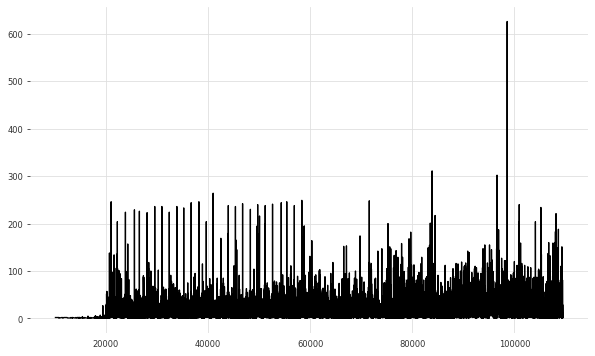

In [16]:
# 尝试画图解释
# 但是太密集了
# 所以以天为单位进行分析
plt.figure(figsize=(10, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(dftcc.minofyear, dftcc.job_name)

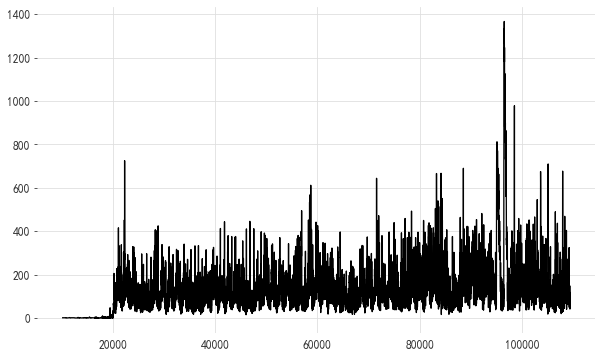

In [38]:

# 10min  a week
plt.figure(figsize=(10, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(dftcc_10min['10minofyear'], dftcc_10min.job_name)

In [19]:
# 寻找第一个 天单位整点整分钟 进行数据截取 
# 根据上图显示 20000 之前的点感觉不连续
# 直接在 20000 分钟之后的第一个点取样
dftcc_job_of_min = dftcc[(dftcc.minofyear>=20160)].set_index('minofyear')[['job_name']]
# 再将 index 进行转换
dftcc_job_of_min = dftcc_job_of_min.reset_index()

In [39]:
dftcc_job_of_10min = dftcc_10min[(dftcc_10min['10minofyear']>=20160)].set_index('10minofyear')[['job_name']]
# 再将 index 进行转换
dftcc_job_of_10min = dftcc_job_of_10min.reset_index()

In [40]:
dftcc_job_of_10min.head()

,10minofyear,job_name
0,20160,148
1,20170,168
2,20180,87
3,20190,206
4,20200,205


In [20]:
dftcc_job_of_min.head()

,minofyear,job_name
0,20160.0,6
1,20161.0,7
2,20162.0,12
3,20163.0,3
4,20164.0,52


#### 以天为单位进行分解
以第一天为单位进行分析

In [44]:
dftcc_job_of_first_day = dftcc_job_of_min.loc[dftcc_job_of_min['minofyear']<=21600]

NameError: name 'dftcc_job_of_min' is not defined

In [41]:
dftcc_job_10min_of_first_day = dftcc_job_of_10min.loc[dftcc_job_of_10min['10minofyear']<=21600]

In [29]:
dftcc_job_of_first_day.head(5)

,minofyear,job_name
0,20160.0,6
1,20161.0,7
2,20162.0,12
3,20163.0,3
4,20164.0,52


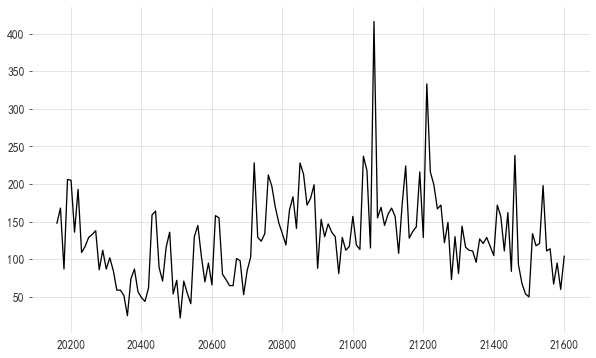

In [42]:

plt.figure(figsize=(10, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(dftcc_job_10min_of_first_day['10minofyear'], dftcc_job_10min_of_first_day.job_name)

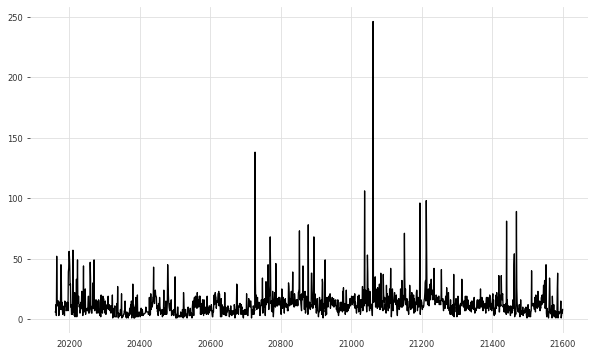

In [28]:
# 尝试画图解释
plt.figure(figsize=(10, 6))
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_columns', 100)
# matplotlib.rcParams.update({"font.size": 16,'lines.linewidth': 2.5})
plt.plot(dftcc_job_of_first_day.minofyear, dftcc_job_of_first_day.job_name)

#### 处理时间戳

In [43]:
dftcc_job_of_first_day['minofyear'] = dftcc_job_of_first_day['minofyear'].apply(lambda x: int(x-20160))

NameError: name 'dftcc_job_of_first_day' is not defined

In [33]:
# 添加时间索引
# 假设在今年1月1日开始
dftcc_job_of_first_day["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(dftcc_job_of_first_day.minofyear, "m")

C:\Users\liduo\AppData\Local\Temp\ipykernel_3364\3556499930.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftcc_job_of_first_day["date"] = pd.Timestamp("2022-01-01") + pd.to_timedelta(dftcc_job_of_first_day.minofyear, "m")


In [34]:
dftcc_job_of_first_day.head()

,minofyear,job_name,date
0,0,6,2022-01-01 00:00:00
1,1,7,2022-01-01 00:01:00
2,2,12,2022-01-01 00:02:00
3,3,3,2022-01-01 00:03:00
4,4,52,2022-01-01 00:04:00


In [58]:
# 从 df 中加载数据
dataset = TimeSeries.from_dataframe(
    dftcc_job_of_first_day, 
    time_col='date',                    # 最好使用 datetime类型作为索引
    value_cols='job_name',
    fill_missing_dates=True,
    fillna_value=10,
    )

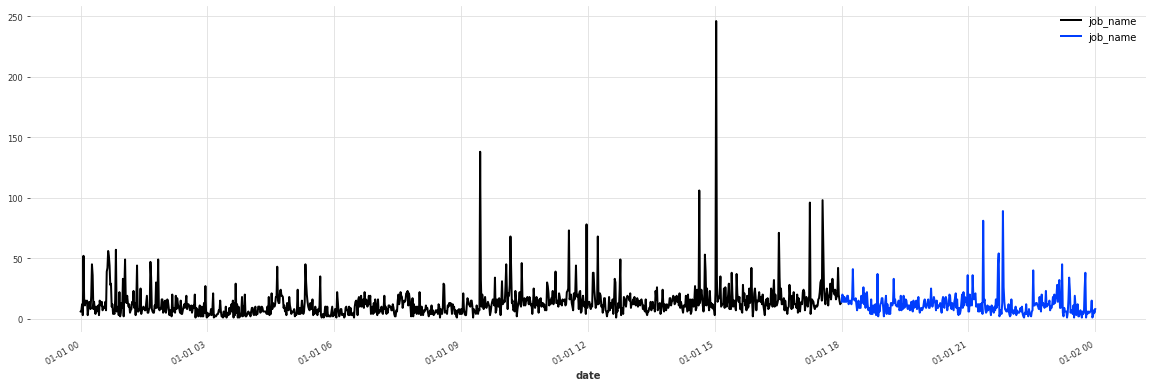

In [59]:
# 划分训练集和测试集
train, val = dataset.split_before(0.75)
plt.figure(figsize=(20, 6))
train.plot()
val.plot()

### ==== 使用TCNModel进行实验 ====
损失太大 收敛慢
效果不好


In [91]:
from darts.models import TCNModel
from darts.utils.likelihood_models import LaplaceLikelihood

model = TCNModel(
    input_chunk_length=240,
    output_chunk_length=30,
    random_state=42,
    likelihood=LaplaceLikelihood(),
)

model.fit(train, epochs=1000, verbose=True)

[2022-06-12 22:25:51,150] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 811 samples.
[2022-06-12 22:25:51,150] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 811 samples.
2022-06-12 22:25:51 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 811 samples.
[2022-06-12 22:25:51,155] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-06-12 22:25:51,155] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
2022-06-12 22:25:51 darts.models.forecasting.tcn_model INFO: Number of layers chosen: 6
[2022-06-12 22:25:51,159] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-12 22:25:51,159] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-12 22:25:51 darts.models.forecasting.torch_forecasting_model INFO: Time ser

Training: 0it [00:00, ?it/s]

Predicting: 26it [00:00, ?it/s]

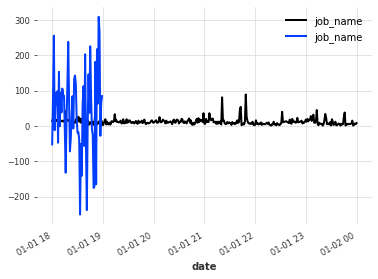

In [97]:
# 记录
# 在进行了1000轮的迭代后 loss降到了17.8 之前是大概8e+10的数量级
# 现在用训练结果进行测试
# 还是向后预测30个样本点
pred = model.predict(n=60, num_samples=1)

#train.plot()
val.plot()
pred.plot()

### ==== TCNModel END ====

### ==== 使用ExponentialSmoothing进行实验 ====
效果不好

In [73]:
from darts.models import ExponentialSmoothing
from darts.utils.utils import SeasonalityMode
model = ExponentialSmoothing(seasonal=SeasonalityMode.NONE)
model.fit(train)


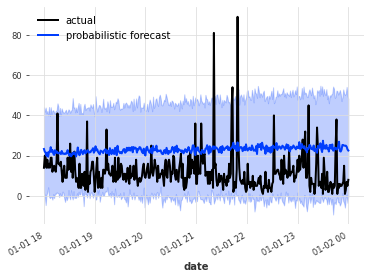

In [76]:
probabilistic_forecast = model.predict(len(val), num_samples=200)
val.plot(label="actual")
probabilistic_forecast.plot(label="probabilistic forecast")
plt.legend()
plt.show()

### ==== 使用NBEATSModel进行实验 ====

In [67]:
from darts.models import NBEATSModel

model = NBEATSModel(input_chunk_length=60, output_chunk_length=30, random_state=42)

model.fit([train], epochs=30, verbose=True)

[2022-06-12 21:31:32,112] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 991 samples.
[2022-06-12 21:31:32,112] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 991 samples.
2022-06-12 21:31:32 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 991 samples.
[2022-06-12 21:31:32,192] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-12 21:31:32,192] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-12 21:31:32 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-12 21:31:32,195] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Training: 0it [00:00, ?it/s]

Predicting: 31it [00:00, ?it/s]

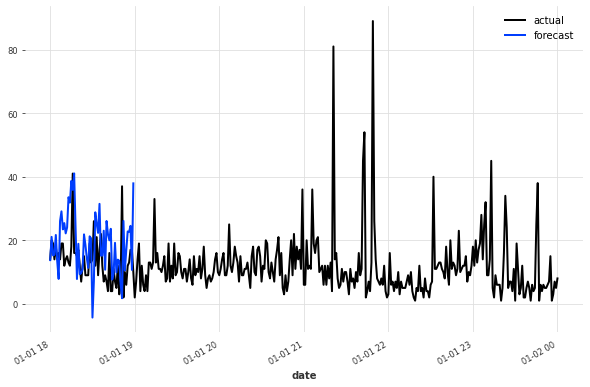

In [69]:
pred = model.predict(series=train, n=60)

plt.figure(figsize=(10, 6))
val.plot(label="actual")
pred.plot(label="forecast")

### ==== NBEATSModel END ====

### ==== RNN ====
效果不好

In [77]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries


In [78]:
# 从 df 中加载数据
dataset_rnn = TimeSeries.from_dataframe(
    dftcc_job_of_first_day, 
    time_col='date',                    # 最好使用 datetime类型作为索引
    value_cols='job_name',
    fill_missing_dates=True,
    fillna_value=10,
    )
train_rnn, val_rnn = dataset_rnn.split_before(0.8)
transformer = Scaler()
train_rnnn_transformed = transformer.fit_transform(train)
val_rnn_transformed = transformer.transform(val)
dataset_rnn_transformed = transformer.transform(dataset_rnn)

In [88]:
rnn_model = RNNModel(
    model="GRU",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    model_name="GRU",
    log_tensorboard=True,
    random_state=42,
    training_length=240,
    input_chunk_length=240,
    force_reset=True,
    save_checkpoints=True,
)

In [89]:
rnn_model.fit(
    train_rnnn_transformed,
    # future_covariates=covariates,
    val_series=val_rnn_transformed,
    # val_future_covariates=covariates,
    verbose=True,
)

[2022-06-12 22:19:48,354] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 840 samples.
[2022-06-12 22:19:48,354] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 840 samples.
2022-06-12 22:19:48 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 840 samples.
[2022-06-12 22:19:48,360] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-06-12 22:19:48,360] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-06-12 22:19:48 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
[2022-06-12 22:19:48,367] WARNING | darts.models.forecasting.torch_forecasting_model | DeprecationWarning: kwarg `verbose` is deprecated and will be removed in a future Darts version. Instead, control verbosity with PyTorch Lightnin

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 53it [00:00, ?it/s]

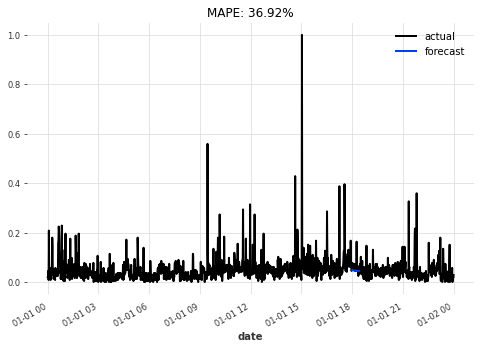

In [90]:

def eval_model(model):
    # pred_series = model.predict(n=26, future_covariates=covariates)
    pred_series = model.predict(n=26)

    plt.figure(figsize=(8, 5))
    dataset_rnn_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_rnn_transformed)))
    plt.legend()


eval_model(rnn_model)

### ==== RNN END ====

In [ ]:
# 缺失值处理
# from darts.utils.missing_values import fill_missing_values

# values = np.arange(50, step=0.5)
# values[10:30] = np.nan
# values[60:95] = np.nan
# series_ = TimeSeries.from_values(values)

# (series_ - 10).plot(label="with missing values (shifted below)")
# fill_missing_values(series_).plot(label="without missing values")

TypeError: 'str' object is not callable